In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import paddle
# 导入训练数据
df_train = pd.read_csv("train.csv")
df_train = df_train.drop(['id'],axis=1)
# 对特征进行归一化
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(df_train.iloc[:,1:])  
scaler_data = scaler.transform(df_train.iloc[:,1:])
# 将训练数据集和测试数据集按照8:2的比例分开
ratio = 0.8
offset = int(df_train.shape[0] * ratio)
train_data = np.c_[scaler_data,df_train.iloc[:,0]][:offset].copy()
test_data = np.c_[scaler_data,df_train.iloc[:,0]][offset:].copy()

In [47]:
# MLP模型组网搭建
n_input = 30
from paddle import nn
class Classifier(paddle.nn.Layer):
    def __init__(self):
        super(Classifier, self).__init__()
        self.l1 = paddle.nn.Linear(n_input, 1,)

    def forward(self, inputs):
        pred = self.l1(inputs)
        return pred

In [53]:
import paddle.nn.functional as F 
y_preds = []
train_nums = []
train_costs = []
labels_list = []
BATCH_SIZE = 20

def train(model):
    print('start training ... ')
    # 开启模型训练模式
    model.train()
    EPOCH_NUM = 5
    train_num = 0
    optimizer = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(train_data)
        # 将训练数据进行拆分，每个batch包含20条数据
        mini_batches = [train_data[k: k+BATCH_SIZE] for k in range(0, len(train_data), BATCH_SIZE)]
        for batch_id, data in enumerate(mini_batches):
            features_np = np.array(data[:, 1:], np.float32)
            labels_np = np.array(data[:, 0], np.float32)
            features = paddle.to_tensor(features_np)
            labels = paddle.to_tensor(labels_np)
            # 前向计算
            y_pred = model(features)
            y_pred = paddle.reshape(y_pred,shape=labels)
            print(y_pred,labels)
            cost = F.binary_cross_entropy_with_logits(y_pred, label=labels)
            train_cost = cost.numpy()[0]
            # 反向传播
            cost.backward()
            # 最小化loss，更新参数
            optimizer.step()
            # 清除梯度
            optimizer.clear_grad()
            
            if batch_id%30 == 0 and epoch_id%50 == 0:
                print("Pass:%d,Cost:%0.5f"%(epoch_id, train_cost))

            train_num = train_num + BATCH_SIZE
            train_nums.append(train_num)
            train_costs.append(train_cost)
        
model = Classifier()
train(model)

start training ... 


c:\Users\Administer\AppData\Local\Programs\Python\Python39\lib\site-packages\paddle\tensor\manipulation.py:1769: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (repeat_times.ndim == 1,
c:\Users\Administer\AppData\Local\Programs\Python\Python39\lib\site-packages\paddle\tensor\manipulation.py:1769: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (repeat_times.ndim == 1,


NotImplementedError: (Unimplemented) Invalid dimension to be accessed. Now only supports access to dimension 0 to 9, but received dimension is 20. (at C:\home\workspace\Paddle_release\paddle/phi/core/ddim.h:53)
  [operator < reshape2 > error]

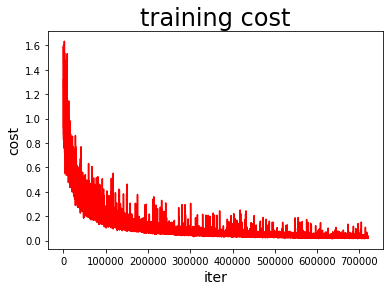

In [15]:
def draw_train_process(iters, train_costs):
    plt.title("training cost", fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs, color='red', label='training cost')
    plt.show()


import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
draw_train_process(train_nums, train_costs)

In [34]:
# 获取预测数据
INFER_BATCH_SIZE = 100

infer_features_np = np.array(test_data[:,1:]).astype("float32")
infer_labels_np = np.array(test_data[:,0]).astype("float32")

infer_features = paddle.to_tensor(infer_features_np)
infer_labels = paddle.to_tensor(infer_labels_np)
fetch_list = model.forward(infer_features)

sum_cost = 0

for i in range(INFER_BATCH_SIZE):
    infer_result = fetch_list[i][0]
    ground_truth = infer_labels[i]
    if i % 10 == 0:
        print("No.%d: infer result is %.2f,ground truth is %.2f" % (i, infer_result, ground_truth))
    cost = paddle.pow(infer_result - ground_truth, 2)
    sum_cost += cost
mean_loss = sum_cost / INFER_BATCH_SIZE
print("Mean loss is:", mean_loss.numpy())

ValueError: (InvalidArgument) Input(Y) has error dim.Y'dims[0] must be equal to 31But received Y'dims[0] is 30
  [Hint: Expected y_dims[y_ndim - 2] == K, but received y_dims[y_ndim - 2]:30 != K:31.] (at C:\home\workspace\Paddle_release\paddle/phi/kernels/impl/matmul_kernel_impl.h:315)
  [operator < matmul_v2 > error]

In [21]:
np.shape(train_data)

(144000, 32)

In [30]:
np.shape(infer_features_np)

(36000, 31)